# Outliers Handling - Traffic Accidents

This notebook explores **3 approaches** to handle outliers:
1. **Drop outliers** - Remove records with outlier values
2. **Replace outliers** - Replace outliers with median values
3. **Truncate outliers** - Cap outliers at threshold boundaries

Each approach is evaluated using Naive Bayes and KNN classifiers.

In [1]:
import sys
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import figure, savefig, show

sys.path.insert(1, '../../../../utils')
from dslabs_functions import get_variable_types, NR_STDEV, determine_outlier_thresholds_for_var
from studies import evaluate_and_plot

In [2]:
filename = "../../data/prepared/traffic_enc1.csv"

In [3]:
file_tag = "traffic"
metric="f1"
lab_folder_out = "lab3_preparation/outliers"
target_name = "crash_type"

data: DataFrame = read_csv(filename, na_values="")
variable_types: dict[str, list] = get_variable_types(data)
numeric_vars = variable_types['numeric']

print(f"Dataset shape: {data.shape}")
print(f"Numeric variables: {len(numeric_vars)}")

Dataset shape: (209306, 150)
Numeric variables: 13


## Approach 1: Drop Outliers

Remove records that contain outlier values (beyond mean ± N*std_dev).

In [4]:
approach_out1 = "drop_outliers"

n_std: int = NR_STDEV
if numeric_vars is not None:
    df_out1: DataFrame = data.copy(deep=True)
    summary5: DataFrame = data[numeric_vars].describe()
    
    for var in numeric_vars:
        top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(summary5[var])
        outliers: Series = df_out1[(df_out1[var] > top_threshold) | (df_out1[var] < bottom_threshold)]
        df_out1.drop(outliers.index, axis=0, inplace=True)
    
    print(f"Original data: {data.shape}")
    print(f"After dropping outliers: {df_out1.shape}")
    print(f"Records removed: {data.shape[0] - df_out1.shape[0]} ({100*(data.shape[0] - df_out1.shape[0])/data.shape[0]:.1f}%)")
else:
    print("There are no numeric variables")

Original data: (209306, 150)
After dropping outliers: (138419, 150)
Records removed: 70887 (33.9%)


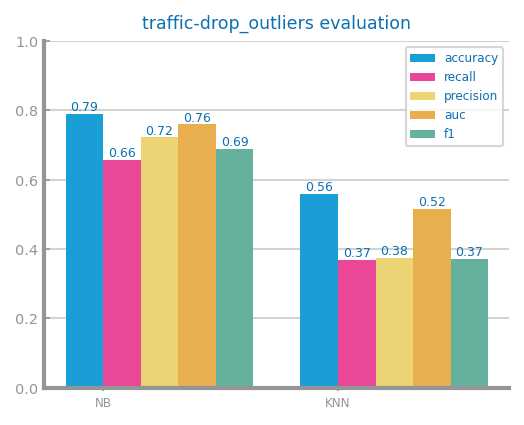

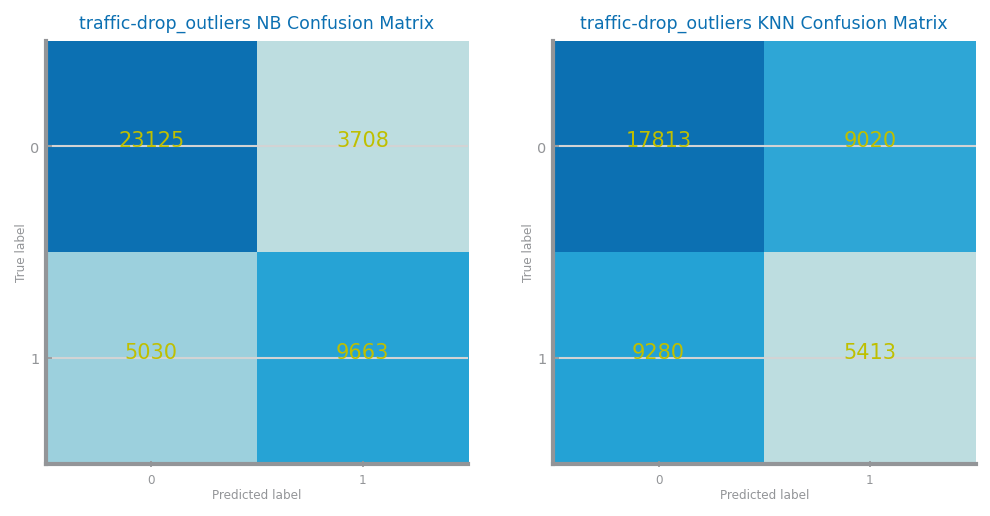

In [5]:
evaluate_and_plot(df_out1, lab_folder_out, file_tag, approach_out1, target_name, metric=metric)

## Approach 2: Replace Outliers with Median

Replace outlier values with the median of the variable.

In [6]:
approach_out2 = "replacing_outliers"

if [] != numeric_vars:
    df_out2: DataFrame = data.copy(deep=True)
    summary5: DataFrame = data[numeric_vars].describe()
    
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        median: float = df_out2[var].median()
        df_out2[var] = df_out2[var].apply(lambda x: median if x > top or x < bottom else x)
    
    print("Data after replacing outliers:", df_out2.shape)
    print(df_out2.describe())
else:
    print("There are no numeric variables")

Data after replacing outliers: (209306, 150)
         crash_date     crash_type  intersection_related_i         damage  \
count  2.093060e+05  209306.000000           209306.000000  209306.000000   
mean   1.609386e+18       0.439213                0.952309       1.803111   
std    7.425389e+16       0.496292                0.213112       0.397649   
min    1.454883e+18       0.000000                0.000000       1.000000   
25%    1.546545e+18       0.000000                1.000000       2.000000   
50%    1.608397e+18       0.000000                1.000000       2.000000   
75%    1.673145e+18       1.000000                1.000000       2.000000   
max    1.737159e+18       1.000000                1.000000       2.000000   

       num_units  most_severe_injury  injuries_total  injuries_fatal  \
count   209306.0       209306.000000   209306.000000        209306.0   
mean         2.0            0.378054        0.183358             0.0   
std          0.0            0.732383        0

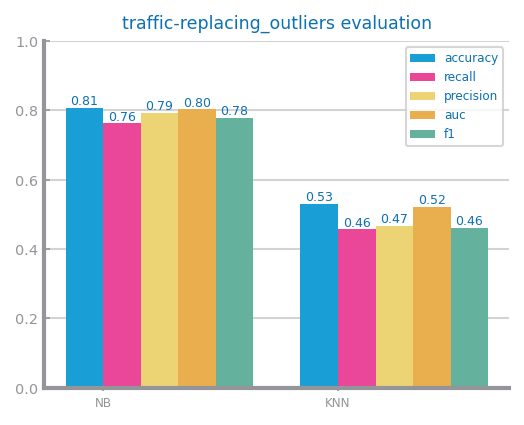

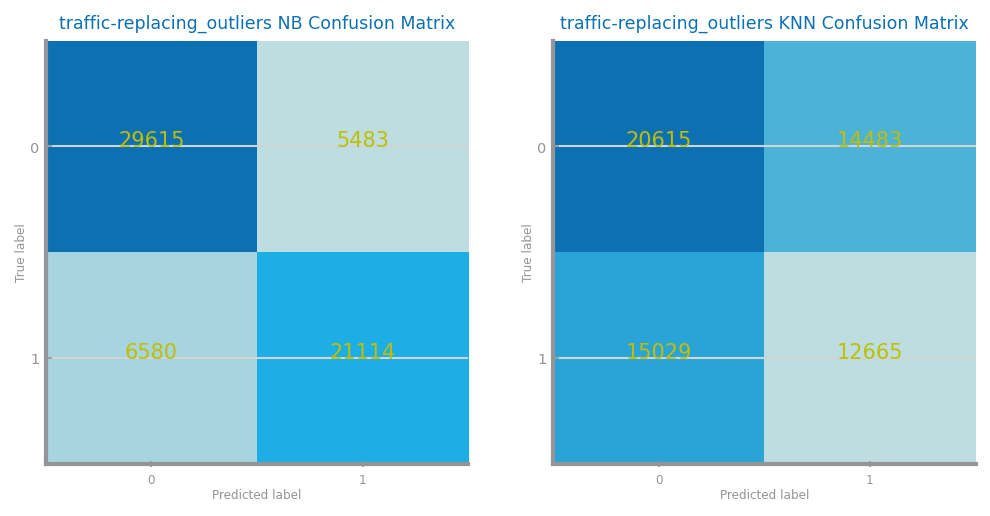

In [7]:
evaluate_and_plot(df_out2, lab_folder_out, file_tag, approach_out2, target_name, metric=metric)

## Approach 3: Truncate Outliers

Cap outlier values at the threshold boundaries (windsorizing).

In [8]:
approach_out3 = "truncate_outliers"

if [] != numeric_vars:
    df_out3: DataFrame = data.copy(deep=True)
    summary5: DataFrame = data[numeric_vars].describe()
    
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        df_out3[var] = df_out3[var].apply(
            lambda x: top if x > top else bottom if x < bottom else x
        )
    
    print("Data after truncating outliers:", df_out3.shape)
    print(df_out3.describe())
else:
    print("There are no numeric variables")

Data after truncating outliers: (209306, 150)
         crash_date     crash_type  intersection_related_i         damage  \
count  2.093060e+05  209306.000000           209306.000000  209306.000000   
mean   1.607552e+18       0.439213                0.952309       1.632463   
std    7.612836e+16       0.496292                0.213112       0.595890   
min    1.454876e+18       0.000000                0.000000       0.281394   
25%    1.543832e+18       0.000000                1.000000       1.000000   
50%    1.608396e+18       0.000000                1.000000       2.000000   
75%    1.673145e+18       1.000000                1.000000       2.000000   
max    1.737159e+18       1.000000                1.000000       2.000000   

           num_units  most_severe_injury  injuries_total  injuries_fatal  \
count  209306.000000       209306.000000   209306.000000   209306.000000   
mean        2.042713            0.451443        0.336197        0.000162   
std         0.250924            

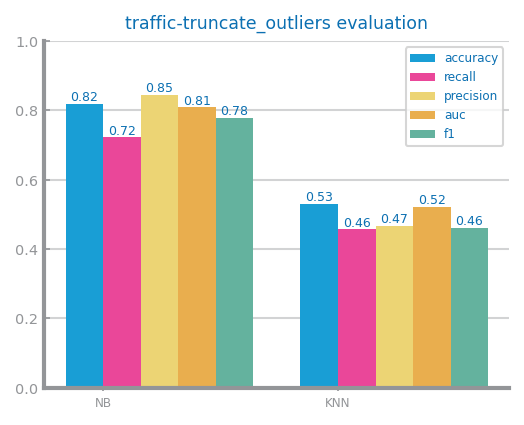

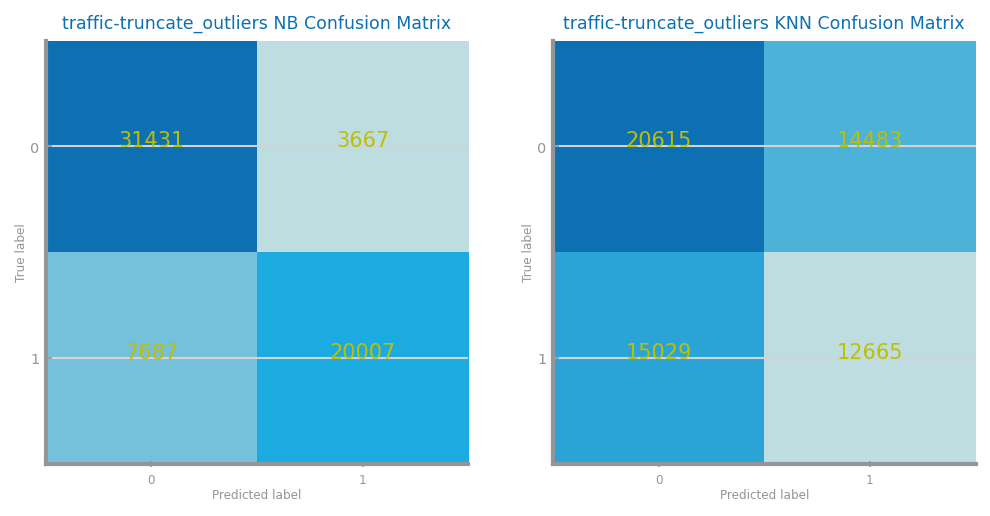

In [9]:
evaluate_and_plot(df_out3, lab_folder_out, file_tag, approach_out3, target_name, metric=metric)

## Save Best Result

Based on evaluation metrics, save the best performing approach.

In [10]:
# Uncomment to save individual results
df_out1.to_csv(f"../../data/prepared/{file_tag}_outliers_{approach_out1}.csv", index=False)
df_out2.to_csv(f"../../data/prepared/{file_tag}_outliers_{approach_out2}.csv", index=False)
df_out3.to_csv(f"../../data/prepared/{file_tag}_outliers_{approach_out3}.csv", index=False)

# Based on original notebook, approach 3 (truncate) was best
best_outliers_df = df_out3.copy()
print(f"Best approach: {approach_out3}")
print(f"Shape: {best_outliers_df.shape}")

Best approach: truncate_outliers
Shape: (209306, 150)
